In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

sns.set_theme()

2023-04-25 09:54:37.159264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 09:54:37.159328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 09:54:37.159335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load data

In [4]:
data = pd.read_pickle('../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../data/data_cond_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (48714, 56, 30) max: 678.0
Loaded cond:  (48714, 12) max: 7000.0 min: -7000.0


In [5]:
data_cond.head()

,Pdg,Energy,Vx,Vy,Vz,Px,Py,Pz,neutron_photon_sum,mass,charge,proton_photon_sum
0,2112,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,1256.0,939.565413,0.0,16.0
1,2212,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,55.0,938.272081,1.0,1195.0
2,310,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,1122.0,497.611000,0.0,23.0
3,2212,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,230.0,938.272081,1.0,78.0
4,2112,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,655.0,939.565413,0.0,34.0


In [6]:
NEUTRON_PROTON_PHOTON_SUM_COLS = ['neutron_photon_sum', 'proton_photon_sum']
neutron_proton_photon_sum_data = data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS]

In [7]:
# drop unnecessary columns
data_cond.drop(columns=['Pdg', 'neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [8]:
CONDITIONAL_COLS = list(data_cond.columns)
CONDITIONAL_COLS

['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge']

1. Flatten the proton responses dataset from shape (56, 30) to (1680, 1)

In [9]:
flatten_responses = pd.DataFrame(data.reshape(len(data), -1))
flatten_responses.shape

(48714, 1680)

2. Concatenate as columns flatten dataset to each conditional row 

In [10]:
data_all = pd.concat([data_cond, flatten_responses], axis=1)
data_all.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,0,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. Groupby each unique combination of conditional data and calculate standard deviation for each pixel in the grouped data

In [55]:
stddev_group = data_all.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers = data_all.groupby(CONDITIONAL_COLS).ngroup()
stddev_group.head()

,0,1,2,3,4,5,6,7,8,9,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
0,0.254516,0.244383,0.307023,0.246475,0.268779,0.273279,0.265414,0.319725,0.319725,0.327021,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.426174,0.512069,0.571778,0.532310,0.590742,0.667918,0.799832,0.989204,0.930898,1.169566,...,0.036564,0.051674,0.00000,0.089462,0.051674,0.0,0.0,0.0,0.051674,0.000000
2,0.262211,0.260189,0.274860,0.294282,0.274860,0.270964,0.387579,0.627706,1.180524,1.185916,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.052058,0.052058
3,0.722909,0.679524,0.705660,0.679306,0.705898,0.807521,0.802229,0.842848,0.910366,0.894244,...,0.000000,0.000000,0.03649,0.036490,0.072981,0.0,0.0,0.0,0.000000,0.036490
4,0.480302,0.427709,0.493697,0.545372,0.491977,0.502993,0.542508,0.511905,0.542273,0.503802,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.036202,0.036202


In [17]:
group_sizes = data_all.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

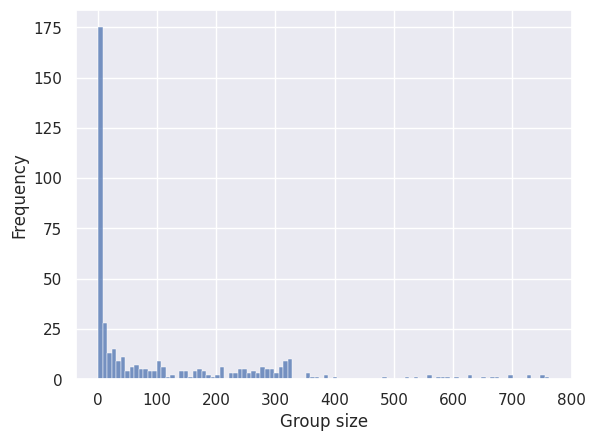

In [27]:
sns.histplot(data=group_sizes, x='Count', bins=100)
plt.xlabel('Group size')
plt.ylabel('Frequency')
plt.show()

In [56]:
groups_numbers.head(), groups_numbers.min(), groups_numbers.max()

(0    316
 1    366
 2    280
 3    317
 4    165
 dtype: int64,
 0,
 435)

4. Calculate sum of stddevs of pixels

In [57]:
sum_pixels = stddev_group.sum(axis=1)
sum_pixels.shape, sum_pixels.head()

((48714,),
 0    154.329429
 1    969.117461
 2    182.483892
 3    265.598939
 4    209.572895
 dtype: float64)

In [58]:
assert data_cond.shape[0] == sum_pixels.shape[0]

5. Divide sum of stddevs by maximum value to normalize it

In [59]:
normalized_stddevs = sum_pixels/sum_pixels.max()

6. Assign calclations to each conditional data

In [60]:
data_cond['std'] = normalized_stddevs

In [61]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628


#### Add informative columns 

In [62]:
data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS] = neutron_proton_photon_sum_data

In [70]:
data_cond['group_number'] = groups_numbers

In [71]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std,neutron_photon_sum,proton_photon_sum,group_number
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311,1256.0,16.0,316
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201,55.0,1195.0,366
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233,1122.0,23.0,280
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331,230.0,78.0,317
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628,655.0,34.0,165


#### Save conditional dataset

In [72]:
data_cond.to_pickle('../data/data_cond_stddev_photonsum_15_2133_15_3273.pkl')